<h1>Pacotes necessários</h1>

<h5>Pacote principal desenvolvido para este projeto</h3>

In [1]:
import LAB_FEEC_UNICAMP as LAB

<h5>Pacotes para a apresentação</h3>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pickle as pk
import IPython
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

<h1>Delay and Sum</h1>

<i>Nesta seção é apresentada a aplicação do delay and sum beamformer para sinais de um arranjo simulados</i>

<h5>Criação e configiração do arranjo linear</h5>

In [3]:
#Demo Audio Files:
#Audios/pulse.wav
#Audios/speech.wav

#Configurate Initial Parameters
c=343.3
#Initialize Array
arr = LAB.Array(c=c)
#Simulates the audio in four microphones and its reflection on the sample
pos_mics = [0.052,0.51,1.03,1.53] #Position of each microphone
pos_mic_amos = 4 #Distance between microphone and the sample
arr.simulatefromWav('Audios/speech.wav',pos_mics,pos_mic_amos,coefInc=1,coefRef=0.2)

<h5>Apresentação dos sinais simulados no tempo</h5>

<IPython.core.display.Javascript object>


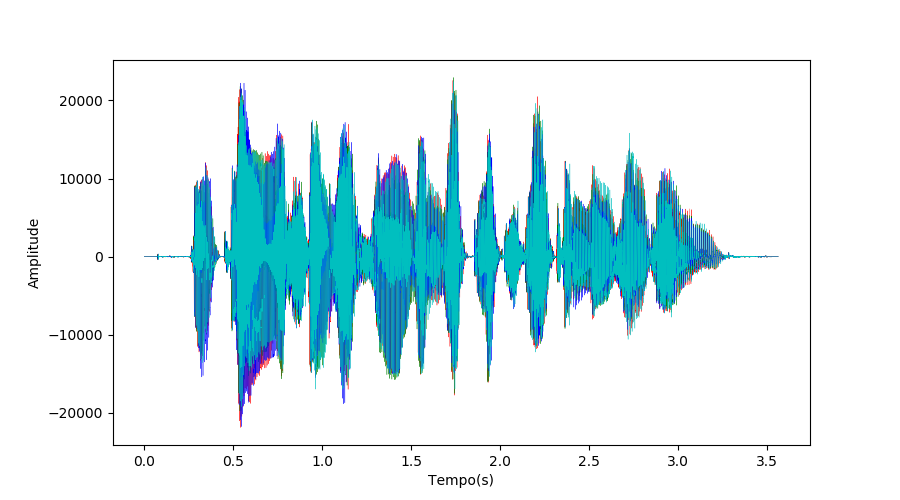

In [4]:
plt.figure('Microphones',figsize=(9,5))
LAB.Plot_Mics_Time(arr)

<h5>Aplicação do DAS (sentido incidente, fonte -> amostra)</h5>

In [5]:
DAS_Inc = LAB.applyDAS(arr, src_to_smpl = True)

<h5>Apresentação no domínio da frequência e do tempo do resultado</h5>

<IPython.core.display.Javascript object>


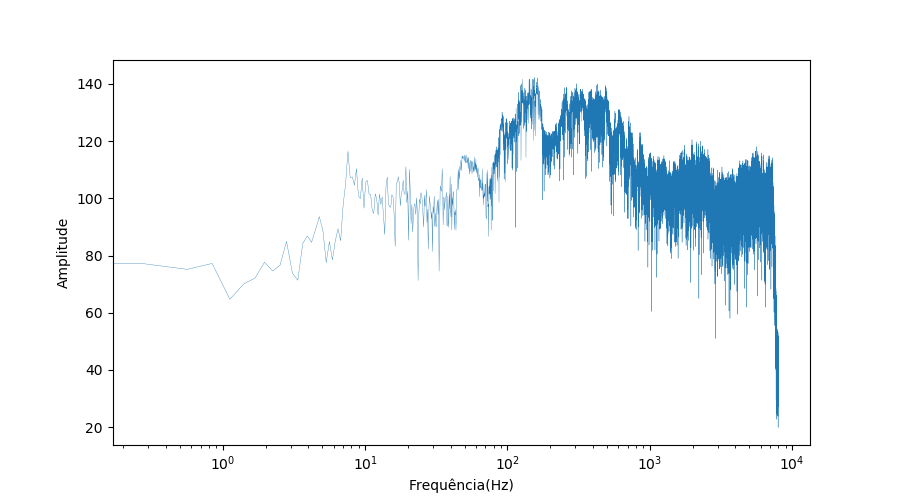

<IPython.core.display.Javascript object>


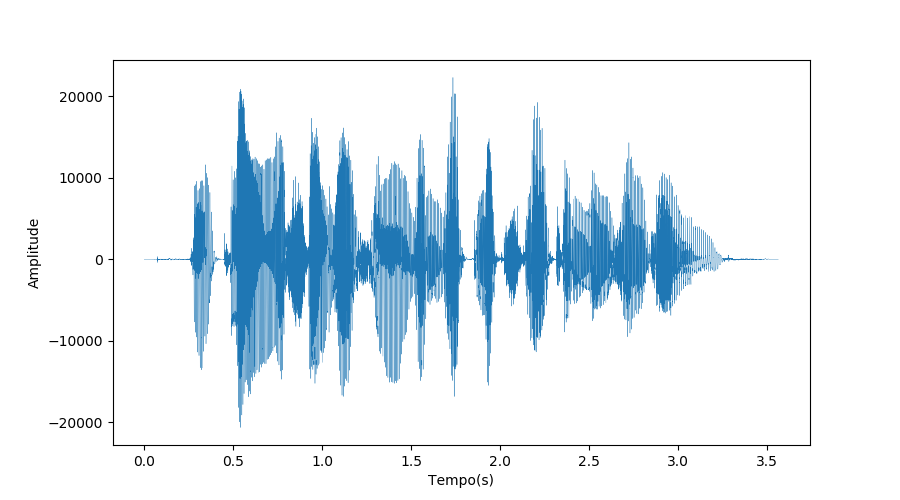

In [6]:
plt.figure('DAS Inc(Spectrum)',figsize=(9,5))
LAB.plotFreq(arr.fs,DAS_Inc)
plt.figure('DAS Inc(Time)',figsize=(9,5))
LAB.plotTime(arr.fs,DAS_Inc)

<h5>Aplicação do DAS (sentido refletido, amostra -> fonte)</h5>

In [7]:
DAS_Refl = LAB.applyDAS(arr, src_to_smpl = False)

<h5>Resultado audível (para o áudio de fala)</h5>

<i>No caso do sinal incidente, o filtro aparenta ser satisfatório.
Porém no caso refletido, podemos perceber o ruído(sinal incidente).</i>

In [8]:
IPython.display.Audio(LAB.toTime(DAS_Inc),rate=arr.fs)

In [9]:
IPython.display.Audio(LAB.toTime(DAS_Refl),rate=arr.fs)

<h1>Minimum Variance Distortionless Response</h1>
<h5>Como detalhado no relatório, existem dois parâmetros principais a serem definidos para o cálculo dos pesos MVDR:</h5>
<ul>
    <li><b>Divisões para covariância</b>: Quantidade de partes em que o sinal será dividido para o calculo da covariância.</li>
    <li><b>Diagonal Loading</b>: Valor adicionado à diagonal da matriz de covariância antes da inversão.</li>
</ul>

In [10]:
Cov_Parts = 47
diagonalLoading = 0 #Adaptative
xmin = 250
xmax = 8000

<h5>Primeiramente, estima-se o sinal de ruído (refletido) utilizando o DAS</h5>

In [11]:
#Estimates noise spectrum
N = LAB.applyDAS(arr, src_to_smpl = False)
Dls = LAB.DeslocSig(N,LAB.calcManifoldVector(arr, False))
N = np.matrix(Dls)

<h5>Com este, é calculado a inversa da matriz covariância</h5>

In [12]:
Rxx = LAB.Beamforming.IterativeCovariance(arr, N, Cov_Parts)
Rxx_inv = LAB.invertRxx(Rxx, diagonalLoading)

<h5>Aplicação do filtro MVDR no arranjo, obtendo o sinal incidente:</h5>

In [13]:
MVDR_Inc = LAB.applyMVDR(arr, src_to_smpl = True, Rxx_inv = Rxx_inv)

<h5>Apresentação no domínio da frequência e do tempo do resultado</h5>

<IPython.core.display.Javascript object>


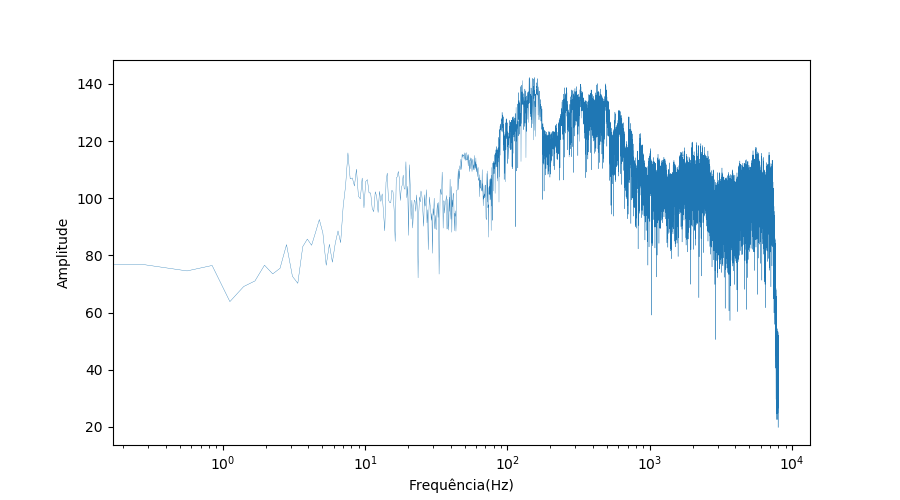

<IPython.core.display.Javascript object>


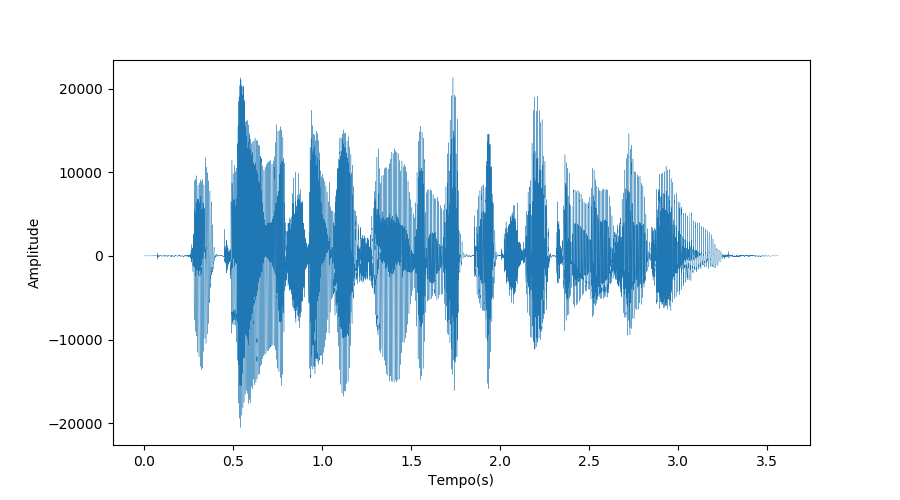

In [14]:
plt.figure('MVDR Inc(Spectrum)',figsize=(9,5))
LAB.plotFreq(arr.fs,MVDR_Inc)
plt.figure('MVDR Inc(Time)',figsize=(9,5))
LAB.plotTime(arr.fs,MVDR_Inc)

<h5>Utiliza-se o resultado(sinal incidente) como ruído na aplicação do MVDR, com o objetivo de obter o sinal refletido.</h5>

In [15]:
Dls = LAB.DeslocSig(MVDR_Inc,LAB.calcManifoldVector(arr, True))
N = np.matrix(Dls)
Rxx_Refl = LAB.IterativeCovariance(arr, N, Cov_Parts)
Rxx_Inv_Refl = LAB.invertRxx(Rxx_Refl,diagonalLoading)
MVDR_Refl = LAB.applyMVDR(arr, False, Rxx_Inv_Refl)

<h5>Resultado audível (incidente e refletido)</h5>

In [16]:
IPython.display.Audio(LAB.toTime(MVDR_Inc),rate=arr.fs)

In [17]:
IPython.display.Audio(LAB.toTime(MVDR_Refl),rate=arr.fs)

Podemos notar que há uma frequência específica ruidosa na filtragem do sinal refletido, devido as caracteristicas do arranjo.
<h5>Razão entre sinal refletido e incidente</h5>

<IPython.core.display.Javascript object>


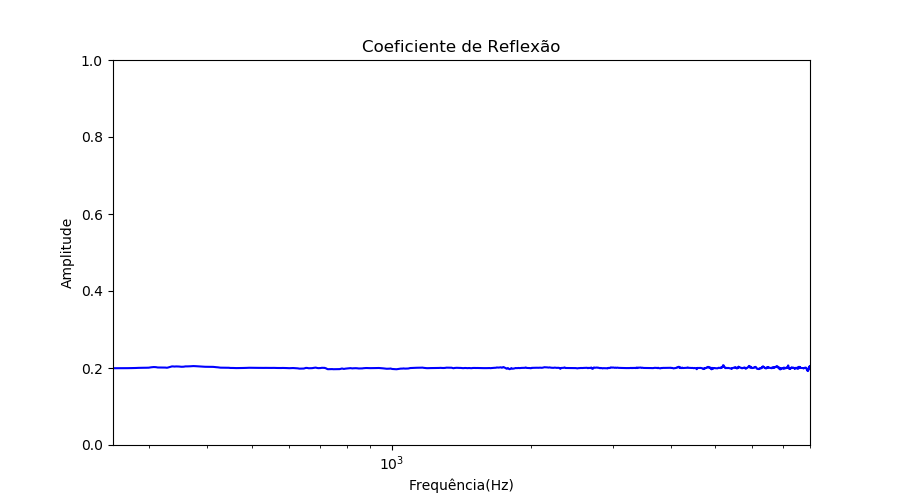

In [18]:
#Refl Coef
plt.figure(figsize=(9,5))
plt.title('Coeficiente de Reflexão')
rate = (np.absolute(MVDR_Refl)/np.absolute(MVDR_Inc))
rate = pd.DataFrame(rate).rolling(300,min_periods=1,center=True).median()._values
plt.xlabel('Frequência(Hz)')
plt.ylabel('Amplitude')
plt.xlim(xmin,xmax)
plt.ylim(0,1)
plt.semilogx(np.linspace(0,arr.fs/2-1,len(MVDR_Refl)),rate,'b')

<h1>Ferramentas utilizadas para o levantamento de diversas filtragens</h1>

<h5>Função que aplica os filtros MVDR no arranjo e salva no arquivo parametrizado</h5>

In [19]:
LAB.Test('Pulse_3_DL0', arr.Microphones[0].signal.Spectrum, arr, 3, 0)

<h5>Função que lê o arquivo e apresenta os resultados</h5>

<IPython.core.display.Javascript object>


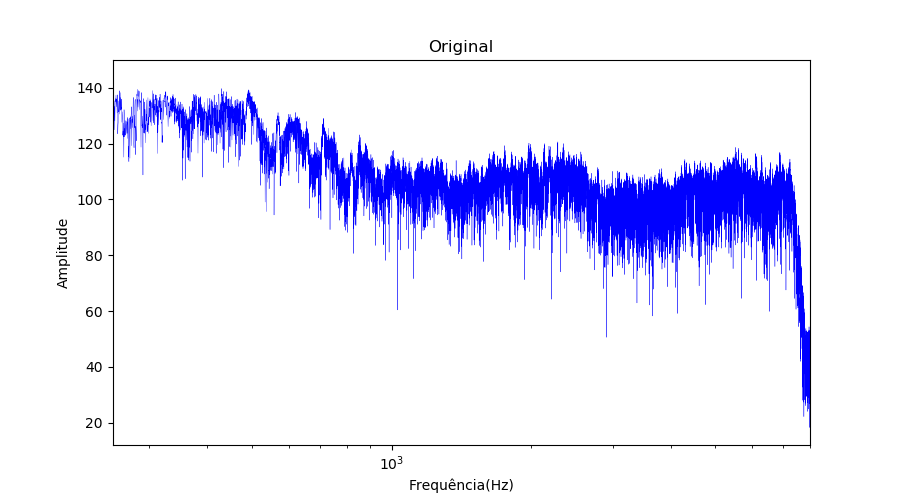

<IPython.core.display.Javascript object>


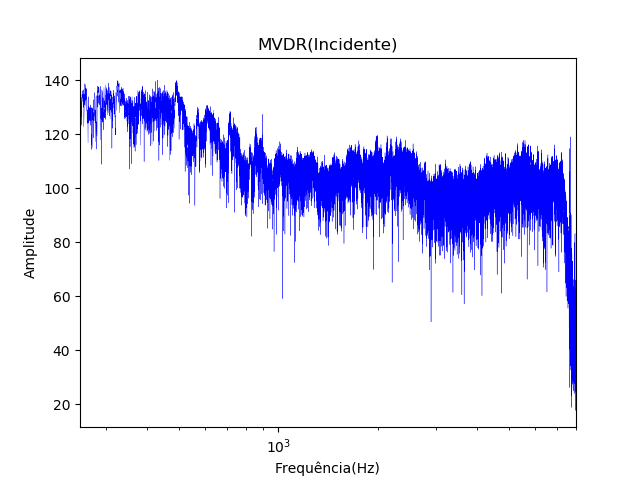

<IPython.core.display.Javascript object>


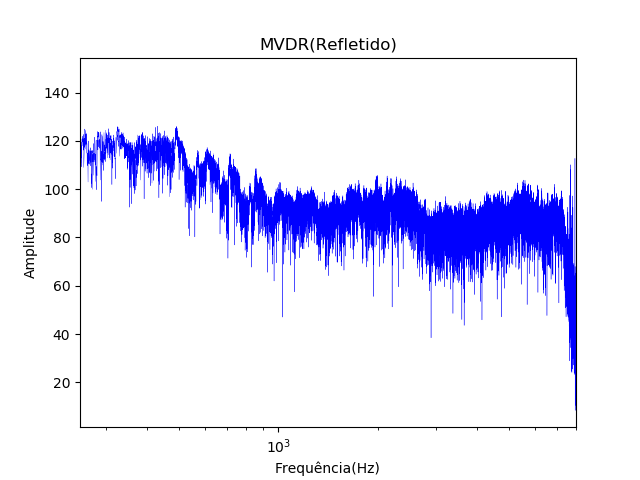

<IPython.core.display.Javascript object>


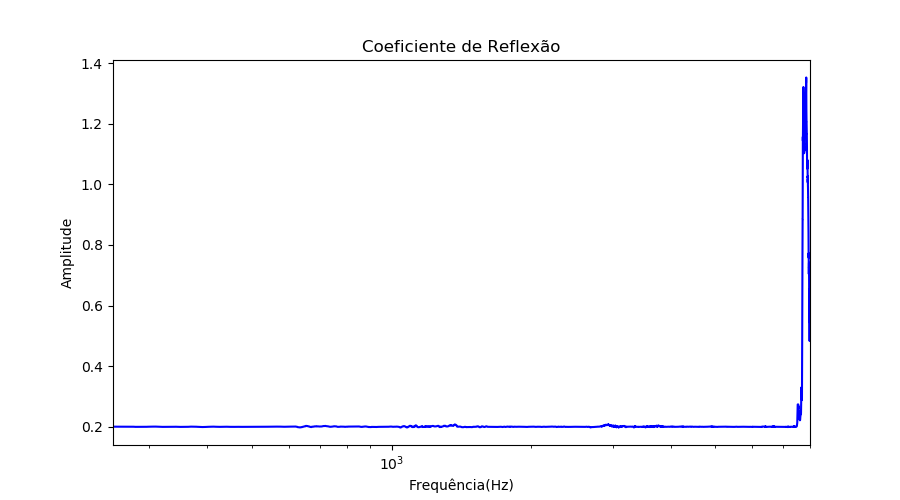

<IPython.core.display.Javascript object>


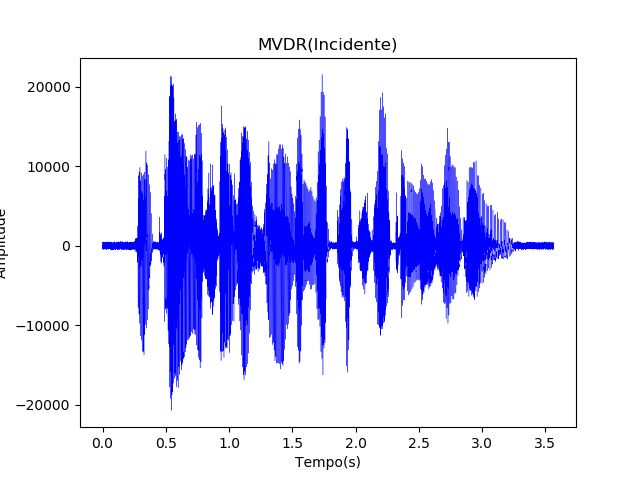

<IPython.core.display.Javascript object>


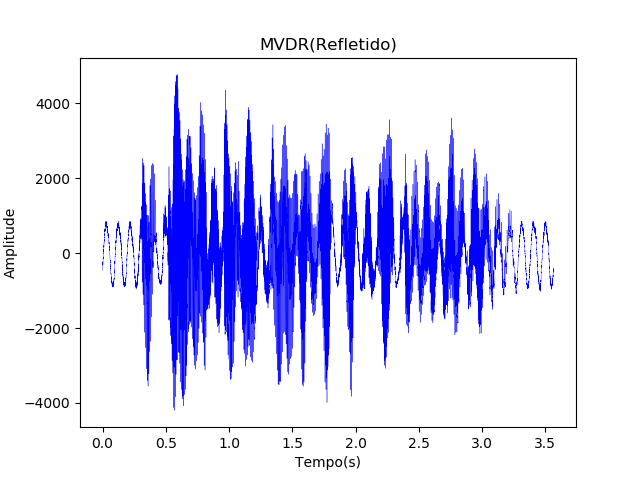

In [20]:
LAB.Show_Data('Pulse_3_DL0', xmin, xmax)